# Wide-angle camera photo transformation

In [160]:
%matplotlib inline
import matplotlib.pyplot as plt
import cv2
import numpy as np
import os

### Import wide-angle image

In [161]:
hamburg = cv2.imread(os.path.join('data', 'hamburg.jpg'))
hamburg.shape

(323, 500, 3)

### Implement functions handling splitting an image

In [162]:
from typing import List

In [163]:
def modulo_split_width(width: int, k: int) -> List:
    """ Split given array into equal but central pieces """
        
    side_width, n_side = width // k, k // 2
    
    # Central rect width depends on the parity of k
    if k % 2 == 0:
        central_width = width % k
    else:
        central_width = side_width + width % k

    # Widths placed symmetrically
    splitted_widths = k//2 * [side_width] + [central_width] + k//2 * [side_width] \
                      if central_width else k//2 * [side_width] + k//2 * [side_width]
    
    return splitted_widths

In [164]:
modulo_split_width(500, 7)

[71, 71, 71, 74, 71, 71, 71]

In [165]:
modulo_split_width(500, 6)

[83, 83, 83, 2, 83, 83, 83]

In [166]:
from itertools import accumulate

In [167]:
def accumulated_modulo_split_width(width: int, k: int) -> List:
    """ Accumulated sums to be passed to np.split """
    
    acc = list(accumulate(modulo_split_width(width, k)))[:-1]
    
    return acc

In [168]:
accumulated_modulo_split_width(500, 7)

[71, 142, 213, 287, 358, 429]

In [169]:
accumulated_modulo_split_width(500, 6)

[83, 166, 249, 251, 334, 417]

In [170]:
def modulo_split_image(image: np.array, k: int) -> List:
    """ Split given image into equal but central pieces """
    
    image_width = image.shape[1]
    
    # Need to copy the image, because np.split alters it
    copy_image = image.copy()
    
    splitted_image = np.split(copy_image, accumulated_modulo_split_width(image_width, k),
                              axis=1)
    
    return splitted_image

In [171]:
modulo_split_image(hamburg, k=7);

In [172]:
def imshow_splitted(images: np.array, k: int = 5) -> None:

    fig, axes = plt.subplots(1, len(images))

    for no, image in enumerate(images):
        axes[no].imshow(image)


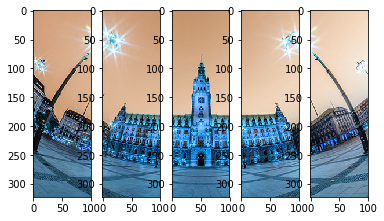

In [173]:
imshow_splitted(modulo_split_image(hamburg, 5))

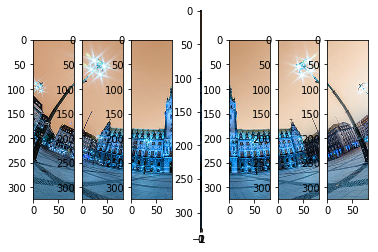

In [174]:
imshow_splitted(modulo_split_image(hamburg, 6))

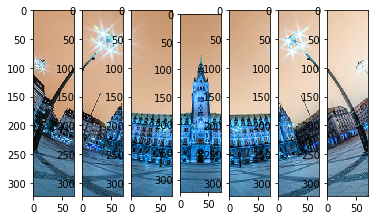

In [175]:
imshow_splitted(modulo_split_image(hamburg, 7))

In [240]:
def imshow_concat(images: np.array, k: int = 5) -> None:
    plt.imshow(np.concatenate(images, axis=1))

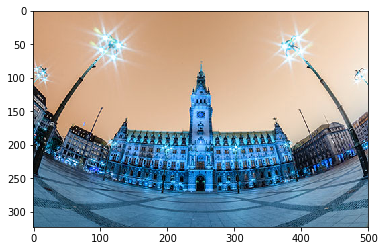

In [241]:
# Ensure if splitting keeps all the data unchanged
imshow_concat(modulo_split_image(hamburg, 6))

### Implement changing perspective

In [217]:
def perspective_transf_fair_division(image: np.array, n_rect: int = 5,
                                     n_pix_change: int = 2) ->  np.array:
    """ Transform images to the new perspective """
    
    # Array of splitted image
    splitted = modulo_split_image(hamburg, n_rect)
          
    width, height = splitted[0].shape[:2]
            
    # Round to floor
    n_side_rect = n_rect // 2
            
    # Create arrays of sets of the new perspective vertexes
    new_perspective_left = np.float32([[[0, 0], 
                                      [i * n_pix_change, width],
                                      [height, 0],
                                      [height - i*n_pix_change, width]] 
                                     for i in range(n_side_rect, 0, -1)])
            
    new_perspective_right = np.float32([[[i * n_pix_change, 0],
                                      [0, width], 
                                      [height - i*n_pix_change, 0],
                                      [height, width]]
                                     for i in range(n_side_rect)])
            
    # Final points of each rect after the transformation
    pts_final = np.float32([[0, 0], [0, width], [height, 0], [height, width]])
            
    # Create arrays of perspective transformation
    new_perspective_left_transformations = [cv2.getPerspectiveTransform(points,
                                                                        pts_final)
                                            for points in new_perspective_left]
        
    new_perspective_right_transformations = [cv2.getPerspectiveTransform(points,
                                                                        pts_final)
                                            for points in new_perspective_right]
           
    # Finally change perspective
    for index in range(n_side_rect):
        splitted[index] = cv2.warpPerspective(splitted[index],
                                              new_perspective_left_transformations[index],
                                              (height, width))
    for index in range(1, n_side_rect + 1):
        splitted[-index] = cv2.warpPerspective(splitted[-index],
                                               new_perspective_left_transformations[-index],
                                               (height, width))
     
    return splitted


### Tests

#### Input image

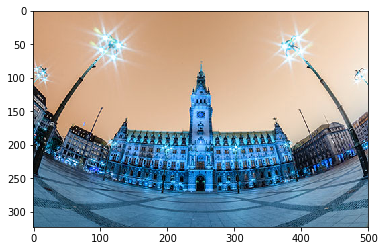

In [228]:
plt.imshow(hamburg)

#### n_rect = 4, n_pix_change = 1

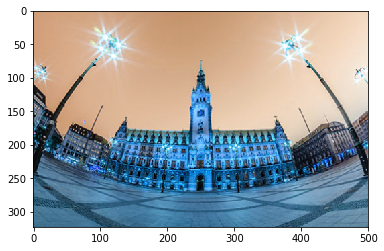

In [242]:
imshow_concat(perspective_transf_fair_division(hamburg, n_rect=4, n_pix_change=1))

#### n_rect = 5, n_pix_change = 1

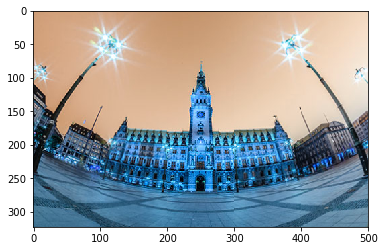

In [243]:
imshow_concat(perspective_transf_fair_division(hamburg, n_rect=5, n_pix_change=1))

#### n_rect = 10, n_pix_change = 1

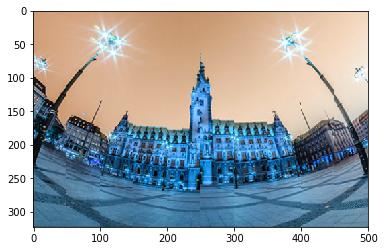

In [244]:
imshow_concat(perspective_transf_fair_division(hamburg, n_rect=10, n_pix_change=1))

#### n_rect = 7, n_pix_change = 2

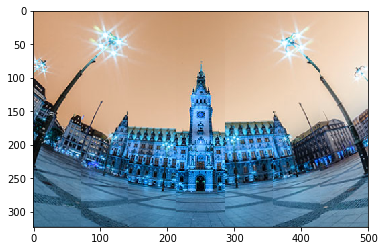

In [245]:
imshow_concat(perspective_transf_fair_division(hamburg, n_rect=7, n_pix_change=2))

#### n_rect = 4, n_pix_change = 2

In [ ]:
imshow_concat(perspective_transf_fair_division(hamburg, n_rect=6, n_pix_change=2))